### Duygu Analizi Fonksiyonumuz. Tüm işlemler bittikten sonra kullanacağız. Kullanmadan önce pytorch indirmeyi ve trasformer'in güncelliğini kontrol etmeliyiz

In [1]:
def sentiment(series, model_name="savasy/bert-base-turkish-sentiment-cased"):
    """
    Tasks
    -----
        Calculates the sentiment of the given series.

    Parameters
    ----------
    series: pandas.Series
        The series to be preprocessed.
    model_name: str (default="savasy/bert-base-turkish-sentiment-cased")
        The name of the model to be used for sentiment analysis.

    Returns
    -------
    label: list
        The sentiment label of the given series.
    score: list
        The sentiment score of the given series.
    """

    from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

    label, score = [], []
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
    for i, k in enumerate(series):
        result = sa(k)
        label.append(result[0]['label'])
        score.append(result[0]['score'])
        if i % 100 == 0 and i != 0:
            print(f"Sentiment analysis of {i} tweets is done")
    return pd.DataFrame({'label': label, 'score': score})


### Kullanacağımız Makine Öğrenmesi Algoritmalarını ve İşlemlerini Bu Fonksiyon ile Çağıracağız

In [2]:
def get_models(x, y, test_size=0.25, random_state=15, classification=False, average='binary', order_type='acc',
               info=False):
    """
    Tasks
    -----
        This functions returns scores of baseline models for classification and regression problems.
    Parameters
    ----------
    x: pandas.DataFrame
        The features of the dataset.
    y: pandas.Series
        The target of the dataset.
    test_size: float (default=0.2)
        The size of the test set.
    random_state: int (default=42)
        The random state of the train test split.
    classification
        If True, the function will work on classification and returns their score.
    average: str (default='binary')
        The average method of the classification report.
    order_type: str (default='acc')
        The order type of the scores. If 'acc', the scores will be ordered by accuracy. If 'f1', the scores will be
        ordered by f1 score. If 'precision', the scores will be ordered by precision score. If 'recall', the scores will
        be ordered by recall score. If 'time' scores will be ordered by time.
    info: bool (default=False)
        If True, the function will print while training.
    Returns
    -------
    print: str
        The scores of the baseline models.
    """

    from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, recall_score
    from sklearn.model_selection import train_test_split

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    all_models = []
    order_types = {'acc': 1, 'precision': 2, 'recall': 3, 'f1': 4, 'time': 5}
    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('GradientBoosting', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            start = timer()
            if info: print(f"{name} is training")
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            acc_test = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average=average)
            recall = recall_score(y_test, y_pred, average=average)
            f1 = f1_score(y_test, y_pred, average=average)
            values = dict(name=name, acc_test=acc_test, precision=precision, recall=recall, f1=f1,
                          train_time=str(timedelta(seconds=(timer() - start)))[-15:])
            if info: print(f"{name} is done in {timedelta(seconds=(timer() - start))}")
            all_models.append(values)
        sort_method = False

    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  ("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            print(f"{name} is training")
            model.fit(x_train, y_train)
            y_pred_test = model.predict(x_test)
            y_pred_train = model.predict(x_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test)
            all_models.append(values)
        sort_method = True

    all_models_df = pd.DataFrame(all_models)
    if order_type == 'time':
        sort_method = True
    all_models_df = all_models_df.sort_values(all_models_df.columns[order_types[order_type]], ascending=sort_method)
    print(f"\nAll models are done --- ordered by {order_type}")
    print(all_models_df.to_markdown())
    return None

### Temel Kütüphaneler(manipülasyon, ön işleme vs. için)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
from alive_progress import alive_bar
import re


### Verimizin En Ham Hali..

In [4]:
dff=pd.read_csv("deprem_1.csv",encoding='utf-8')
dff.head()

,Unnamed: 0,content
0,0,@odatv Bi sormak gerek; hristiyan avrupada ned...
1,1,Az önce sanki bir deprem oldu
2,2,"bi devir bitti kabul edelim, hadi söyle biz de..."
3,3,#osenebusene eytli olmadık busene eytli olalım...
4,4,"#Eyt99SonuHakkımız\nHaziranda mezun olduk ,anc..."


### Ben tercihen topic modellemeye geçmeden önce verimi temizledim. Bu işlemi sonra da yapabilirdik.

## Veri Ön İşleme

In [5]:
def preprocessing(series, remove_hashtag=False, remove_mentions=False, remove_links=False, remove_numbers=False,
                  remove_short_text=False, remove_stopwords=False, lowercase=False, remove_punctuation=False,
                  remove_rare_words=False, rare_limit=5):
    if lowercase:
        print("Lowercasing...")
        start = timer()
        series = series.str.lower()
        print(f"Lowercasing is done in {timedelta(seconds=timer() - start)}")

    if remove_hashtag:
        print("Removing hashtags...")
        start = timer()
        series = series.str.replace(r'((#)[^\s]*)\b', '', regex=True)
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_mentions:
        print("Removing mentions...")
        start = timer()
        series = series.str.replace(r'((@)[^\s]*)\b', '', regex=True)
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_links:
        print("Removing links...")
        start = timer()
        series = series.str.replace(r'\n', '', regex=True)
        series = series.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_numbers:
        print("Removing numbers...")
        start = timer()
        series = series.str.replace(r'\d+', '', regex=True)
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_short_text:
        print("Removing short texts...")
        start = timer()
        series = series.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_stopwords:
        print("Removing stopwords...")
        start = timer()
        with open('stopwords.txt', 'r', encoding='utf-8') as f:
            stop = [line.strip() for line in f]
        series = series.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop]))
        print(f"Stopwords are removed in {timedelta(seconds=timer() - start)}")

    if remove_punctuation:
        print("Removing punctuation...")
        start = timer()
        series = series.str.replace(r"((')[^\s]*)\b", '', regex=True)
        series = series.str.replace(r'[^\w\s]', '', regex=True)
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    if remove_rare_words:
        print("Removing rare words...")
        start = timer()
        whole_count = pd.Series(" ".join(series).split()).value_counts()
        print(f"There are {whole_count.count()} words in the series")
        print(f"%{round(whole_count[whole_count <= rare_limit].count() / whole_count.count() * 100, 2)} of "
              f"words appear lesser than rare limit ({rare_limit}) times")
        to_remove = whole_count[whole_count <= rare_limit]
        print(f"Removing rare words...")
        series = series.apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))
        print(f"{len(to_remove)} rare words removed")
        print(f"Removed in {timedelta(seconds=timer() - start)}")

    return series

### Çalışma alanımızı genişletmek ve verimi artırmak adına TR-EN çeviri fonksiyonu

In [6]:
def tr_en_char_translate(series):
    """
    Tasks
    -----
        Convert Turkish characters to English characters.

    Parameters
    ----------
    series: pandas.Series
        The series to be translated.

    Returns
    -------
    series: pandas.Series
        The translated series.
    """
    series = series.str.replace('ı', 'i')
    series = series.str.replace('ü', 'u')
    series = series.str.replace('ö', 'o')
    series = series.str.replace('ğ', 'g')
    series = series.str.replace('ş', 's')
    series = series.str.replace('ç', 'c')
    return series

### tfidf fonksiyonu bizim öznitelik çıkarımı yaptığımız fonksiyon. Yani, bir terimin belgedeki herhangi bir konumda kaç kez geçtiğini sayar.TF = (Terimin belgedeki toplam sayısı) / (Belgedeki toplam terim sayısı). Ve Bir terimin belgedeki tüm belgelerde ne kadar yaygın olduğunu ölçer.IDF = log((Toplam belge sayısı) / (Terimi içeren belge sayısı))

In [7]:
def create_tfidf(series):
    """
    Tasks
    -----
        Creates tfidf matrix for the given series.

    Parameters
    ----------
    series: pandas.Series
        The series to be transformed.

    Returns
    -------
    df_tfidf_vect: pandas.DataFrame
        The tfidf matrix.
    """

    from sklearn.feature_extraction.text import TfidfVectorizer

    tfidf_vectorized = TfidfVectorizer(analyzer='word')
    tfidf_wm = tfidf_vectorized.fit_transform(series)
    tfidf_tokens = tfidf_vectorized.get_feature_names_out()
    df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

    return df_tfidf_vect

### Tweetler veri setindeki content sütunun altında olduğu için fonksiyon atamasını bu değişken üzerine yapıyoruz.

In [8]:
dff['content']

dff['content']= preprocessing(dff['content'], 
                                    remove_hashtag=True, 
                                    remove_mentions=True, 
                                    remove_links=True, 
                                    remove_numbers=True, 
                                    remove_short_text=True, 
                                    remove_stopwords=True, 
                                    lowercase=True, 
                                    remove_punctuation=True, 
                                    remove_rare_words=False)

print(dff['content'])

Lowercasing...
Lowercasing is done in 0:00:00.029567
Removing hashtags...
Removed in 0:00:00.028265
Removing mentions...
Removed in 0:00:00.023372
Removing links...
Removed in 0:00:00.047423
Removing numbers...
Removed in 0:00:00.071332
Removing short texts...
Removed in 0:00:00.111950
Removing stopwords...
Stopwords are removed in 0:00:07.056320
Removing punctuation...
Removed in 0:00:00.074054
0        sormak gerek hristiyan avrupada şiddetli depre...
1                                                   deprem
2        devir bitti kabul edelim söyle bilelim beni sa...
3        eytli olmadık busene eytli olalım magdurları u...
4        haziranda mezun olduk ancak daki deprem atamal...
                               ...                        
29995    chp despotizminden cumhuriyet  işte geçtiğimiz...
29996    kibirhalis bayancuk hocahalil falyalıahmet hak...
29997      çocuklu kadın tiktok tanıştığı evli adama kaçtı
29998    mısır modern tarihi  kavalalı mehmed ali paşa ...
29999      

In [9]:
dff.head()

,Unnamed: 0,content
0,0,sormak gerek hristiyan avrupada şiddetli depre...
1,1,deprem
2,2,devir bitti kabul edelim söyle bilelim beni sa...
3,3,eytli olmadık busene eytli olalım magdurları u...
4,4,haziranda mezun olduk ancak daki deprem atamal...


In [10]:
dff = dff.drop('Unnamed: 0', axis=1) 

In [11]:
dff.head()

,content
0,sormak gerek hristiyan avrupada şiddetli depre...
1,deprem
2,devir bitti kabul edelim söyle bilelim beni sa...
3,eytli olmadık busene eytli olalım magdurları u...
4,haziranda mezun olduk ancak daki deprem atamal...


### Temizlenmiş verilerimizi yeni excel dosyasına aktarıyoruz. Csv şeklinde kaydettiğimde harflerde form bozukluğu oluyordu(encoding/utf-8 ayarlaması yapmama rağmen). Sonrasında csv utf-8 ; ile ayrılmış şeklinde ya da herhangi formatta kaydedebiliriz.

In [12]:
dff.to_excel("cleanedTweets.xlsx",index=False)

## Excelde Topic Modelleme Yapıp Kodlamaya Devam Edeceğiz..

## Devam ediyoruz..

In [13]:
df=pd.read_csv("learningTweets.csv",sep=";")
df.tail()

,tweets,Afet,Siyasi,Mağduriyet
499,yunan siyasetinde küçük çaplı deprem yunanista...,0,1,0
500,seçim vaatlerinden hangilerini yüzde kaçını ge...,0,1,0
501,seçime gidiliyor hükümetin attığı akıllıca adı...,0,1,0
502,ümit özdağ parti gider masa gelirse fetö döner,0,1,0
503,itibariyle vergi sistemi sınırlarımız muhalefe...,0,1,0


### TR-EN harf Dönüşümü: Yukarıda oluşturduğumuz translate fonksiyonunu burada devreye sokup Türkçe karakterleri İngilizce karakterlere dönüştüreceğiz.

In [14]:
df['islenmis_veri_non_turkish_char'] = tr_en_char_translate(df['tweets'])
df.head()

,tweets,Afet,Siyasi,Mağduriyet,islenmis_veri_non_turkish_char
0,hatay çevre illerde hissedilen sonrası can mal...,1,0,0,hatay cevre illerde hissedilen sonrasi can mal...
1,hatay kırıkhan ilçesinde büyüklüğünde deprem ...,1,0,0,hatay kirikhan ilcesinde buyuklugunde deprem ...
2,afad yapılan açılamaya hatay şiddetinde depre...,1,0,0,afad yapilan acilamaya hatay siddetinde depre...
3,hatay meydana gelen şiddetindeki deprem çevre...,1,0,0,hatay meydana gelen siddetindeki deprem cevre...
4,hatay kırıkhan merkezli şiddetinde deprem meyd...,1,0,0,hatay kirikhan merkezli siddetinde deprem meyd...


In [15]:
df['tweets']=df['islenmis_veri_non_turkish_char']

In [16]:
df = df.drop('islenmis_veri_non_turkish_char', axis=1)
df.head()

,tweets,Afet,Siyasi,Mağduriyet
0,hatay cevre illerde hissedilen sonrasi can mal...,1,0,0
1,hatay kirikhan ilcesinde buyuklugunde deprem ...,1,0,0
2,afad yapilan acilamaya hatay siddetinde depre...,1,0,0
3,hatay meydana gelen siddetindeki deprem cevre...,1,0,0
4,hatay kirikhan merkezli siddetinde deprem meyd...,1,0,0


### Öznitelik Çıkarımı: Yukarıda tanımladığımız TFIDF işlemlerini yapacağız

In [17]:
tf_idf_set = create_tfidf(df['tweets'])
tf_idf_set.head()

,abd,abi,abimiz,abisi,abla,ablamin,abluka,abo,acaba,acamayanbeceriksizlere,...,zmityahyakaptan,zor,zorluklar,zorunda,zorundayim,zorundayiz,zorundayizbuyukluk,zorunlu,zulmdur,zulum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df['deneme'] = preprocessing(df.tweets, remove_rare_words=True, rare_limit=0)

Removing rare words...
There are 3514 words in the series
%0.0 of words appear lesser than rare limit (0) times
Removing rare words...
0 rare words removed
Removed in 0:00:00.017228


3514 adet nadir kelime var. Onlardan Kurtuluyoruz

### Algoritmaların Performansı: Her topic'imizi ayrı şekilde get_model fonksiyonumuz aracılığıyla belirlenen algoritmalara sokuyoruz. Hangi topic'te hangi algoritmanın daha iyi performans gösterdiğini tespit ediyoruz

In [19]:
get_models(tf_idf_set, df.Afet, classification=True, info=True)
# Afet, en iyi RF ile çalıştı.

get_models(tf_idf_set, df.Siyasi, classification=True, info=True)
# Siyasi, en iyi GradientBoosting ile çalıştı.

get_models(tf_idf_set, df.Mağduriyet, classification=True, info=True)
# Mağduriyet, en iyi KNN ile çalıştı.

LR is training
LR is done in 0:00:00.117767
KNN is training
KNN is done in 0:00:00.159125
CART is training
CART is done in 0:00:00.102325
RF is training
RF is done in 0:00:00.392838
SVM is training
SVM is done in 0:00:00.179518
GradientBoosting is training


C:\Users\Uveys\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoosting is done in 0:00:01.856628
LightGBM is training
[LightGBM] [Info] Number of positive: 123, number of negative: 255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325397 -> initscore=-0.729079
[LightGBM] [Info] Start training from score -0.729079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\Uveys\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoosting is done in 0:00:01.805617
LightGBM is training
[LightGBM] [Info] Number of positive: 132, number of negative: 246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349206 -> initscore=-0.622530
[LightGBM] [Info] Start training from score -0.622530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\Uveys\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoosting is done in 0:00:01.702590
LightGBM is training
[LightGBM] [Info] Number of positive: 123, number of negative: 255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325397 -> initscore=-0.729079
[LightGBM] [Info] Start training from score -0.729079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

### Tüm verilerimizi tekrar çağırıyoruz

In [20]:
deprem = pd.read_csv('deprem_1.csv')

In [21]:
deprem.tail()

,Unnamed: 0,content
29995,29995,@caglarcilara Chp despotizminden Cumhuriyet'e ...
29996,29996,"Kibir.(Halis Bayancuk Hoca)\n\n""Halil Falyalı""..."
29997,29997,4 çocuklu kadın TikTok'tan tanıştığı evli adam...
29998,29998,Mısır Modern Tarihi (6): Kavalalı Mehmed Ali P...
29999,29999,@smafatmabetul Fatmabetūl'ūn bizlere ihtiyacı ...


In [22]:
deprem = deprem.drop('Unnamed: 0', axis=1) 

In [23]:
deprem.tail(20)

,content
29980,"Erdoğan: 13 yaşında nişan, 14 yaşında evlilik ..."
29981,@smafatmabetul Eller birleşince gūçlenir #Şart...
29982,Hatırlayalım; Şahan Gökbakar nam-diğer Recep İ...
29983,#eytistemiyoruz\n#deprem\nAMERİKANIN O ÇOCUKLA...
29984,Amerikan Adalet Bakanlığı en büyük kripto bors...
29985,Güzelliği Yüzünden 25 Yıl Boyunca Bir Odaya Ka...
29986,"""herkes gider, Allah kalır.""#deprem https://t...."
29987,@smafatmabetul Fatma betūlū yaşatalım #ŞartlıE...
29988,"Ahmet Hakan, Recep İvedik 7 hakkında konuştu:\..."
29989,@aliduman_ads Ali bey desteğiniz bize güç veri...


In [24]:
deprem['temizlenmis'] = preprocessing(deprem.content, remove_links=True, remove_mentions=True,
                                           remove_hashtag=True, lowercase=True,remove_stopwords=True,remove_numbers=True,
                                           remove_punctuation=True)
deprem["duygu_analizi"]=preprocessing(deprem.content, remove_links=True, remove_mentions=True,
                                           remove_hashtag=True, lowercase=True, remove_numbers=True,
                                           remove_punctuation=True)

Lowercasing...
Lowercasing is done in 0:00:00.034973
Removing hashtags...
Removed in 0:00:00.028656
Removing mentions...
Removed in 0:00:00.022972
Removing links...
Removed in 0:00:00.049650
Removing numbers...
Removed in 0:00:00.069919
Removing stopwords...
Stopwords are removed in 0:00:07.409149
Removing punctuation...
Removed in 0:00:00.073094
Lowercasing...
Lowercasing is done in 0:00:00.024453
Removing hashtags...
Removed in 0:00:00.024894
Removing mentions...
Removed in 0:00:00.019745
Removing links...
Removed in 0:00:00.042200
Removing numbers...
Removed in 0:00:00.065736
Removing punctuation...
Removed in 0:00:00.084490


In [25]:
deprem.tail(10)

,content,temizlenmis,duygu_analizi
29990,Yaaa İstanbul'da deprem falan oldum mu sabah u...,istanbul deprem oldum uyandım deprem sanarak s...,yaaa istanbul deprem falan oldum mu sabah uyan...
29991,Kısmetse Olur yarışmacıları kimdir? Aşklar ili...,kısmetse olur yarışmacıları kimdir aşklar iliş...,kısmetse olur yarışmacıları kimdir aşklar iliş...
29992,Sizce\n\nCumhurbaşkanı Recep Tayyip Erdoğan'ı ...,sizcecumhurbaşkanı recep tayyip erdoğan sevmiy...,sizcecumhurbaşkanı recep tayyip erdoğan neden ...
29993,Depremi anlatırken çocuklara ciğerlerimi de su...,depremi anlatırken çocuklara ciğerlerimi sundu...,depremi anlatırken çocuklara ciğerlerimi de su...
29994,Lan yine mi deprem olmuş sikicem böyle işi ya,deprem olmuş sikicem işi,lan yine mi deprem olmuş sikicem böyle işi ya
29995,@caglarcilara Chp despotizminden Cumhuriyet'e ...,chp despotizminden cumhuriyet eh işte geçtiğim...,chp despotizminden cumhuriyet eh işte geçtiği...
29996,"Kibir.(Halis Bayancuk Hoca)\n\n""Halil Falyalı""...",kibirhalis bayancuk hocahalil falyalıahmet hak...,kibirhalis bayancuk hocahalil falyalıahmet hak...
29997,4 çocuklu kadın TikTok'tan tanıştığı evli adam...,çocuklu kadın tiktok tanıştığı evli adama kaçtı,çocuklu kadın tiktok tanıştığı evli adama kaçtı
29998,Mısır Modern Tarihi (6): Kavalalı Mehmed Ali P...,mısır modern tarihi kavalalı mehmed ali paşa ...,mısır modern tarihi kavalalı mehmed ali paşa ...
29999,@smafatmabetul Fatmabetūl'ūn bizlere ihtiyacı ...,fatmabetūl bizlere ihtiyacı var,fatmabetūl bizlere ihtiyacı var


### TIFIDF Vectorizer: Burada metin verilerimiz tfıdf vectorizer ile vektörlere dönüştürülüp temsil edilir. learning ve gerçek veri setimiz arasındaki tahminlemenin zeminini hazırlar

In [26]:
# Makine Öğrenmesi
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorized = TfidfVectorizer(analyzer='word')
tf_idf_donusturucu = tfidf_vectorized.fit(df['tweets'])

ogrenme_seti = tf_idf_donusturucu.transform(df['tweets'])
ogrenme_seti_vectoru = pd.DataFrame(data=ogrenme_seti.toarray(), columns=tf_idf_donusturucu.get_feature_names_out())


tahmin_seti = tf_idf_donusturucu.transform(deprem.temizlenmis)
tahmin_seti_vectoru = pd.DataFrame(data=tahmin_seti.toarray(), columns=tf_idf_donusturucu.get_feature_names_out())
print("bitti")

bitti


### Model Kurma ve Tahminleme: Burada her topiğimizi ayrı ayrı tahminliyoruz

In [27]:
# Eğitim ve Tahminleme

# Afet Topic'i
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(ogrenme_seti_vectoru, df.Afet)
deprem['Afet'] = model.predict(tahmin_seti_vectoru)


# Siyasi Topic'i
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(ogrenme_seti_vectoru, df.Siyasi)
deprem['Siyasi'] = model.predict(tahmin_seti_vectoru)

# Mağduriyet Topic'i
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(ogrenme_seti_vectoru, df.Mağduriyet)
deprem['Mağduriyet'] = model.predict(tahmin_seti_vectoru)

deprem.head()


[LightGBM] [Info] Number of positive: 163, number of negative: 341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 504, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.323413 -> initscore=-0.738132
[LightGBM] [Info] Start training from score -0.738132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,content,temizlenmis,duygu_analizi,Afet,Siyasi,Mağduriyet
0,@odatv Bi sormak gerek; hristiyan avrupada ned...,bi sormak gerek hristiyan avrupada şiddetli de...,bi sormak gerek hristiyan avrupada neden şidd...,1,0,0
1,Az önce sanki bir deprem oldu,deprem,az önce sanki bir deprem oldu,1,0,0
2,"bi devir bitti kabul edelim, hadi söyle biz de...",bi devir bitti kabul edelim söyle bilelim beni...,bi devir bitti kabul edelim hadi söyle biz de ...,1,0,0
3,#osenebusene eytli olmadık busene eytli olalım...,eytli olmadık busene eytli olalım magdurları u...,eytli olmadık busene eytli olalım magdurlar...,0,0,0
4,"#Eyt99SonuHakkımız\nHaziranda mezun olduk ,anc...",haziranda mezun olduk ancak daki deprem atamal...,haziranda mezun olduk ancak daki deprem ile a...,1,0,0


###  Topiklerin sayılarına bakıyoruz

In [28]:
deprem[["Afet","Siyasi","Mağduriyet"]].value_counts()

Afet  Siyasi  Mağduriyet
1     0       0             18575
0     0       0              8716
              1              1604
1     0       1               648
0     1       0               374
1     1       0                73
0     1       1                10
dtype: int64

In [29]:
deprem.Afet.value_counts()

1    19296
0    10704
Name: Afet, dtype: int64

In [30]:
deprem.Siyasi.value_counts()

0    29543
1      457
Name: Siyasi, dtype: int64

In [31]:
deprem.Mağduriyet.value_counts()

0    27738
1     2262
Name: Mağduriyet, dtype: int64

### Hiçbir topicle eşleşmemiş satır sayısı

In [32]:
# Afet, Siyasi ve Mağduriyet'nin 0 olduğu satırlar
len(deprem[(deprem.Afet == 0) & (deprem.Siyasi == 0) & (deprem.Mağduriyet == 0)])

8716

### Duygu Analizine Başlıyoruz

In [33]:
import transformers                                                                                                                                                                            
transformers.is_torch_available() 

True

In [34]:
deprem['duygu_analizi'] = deprem.duygu_analizi.astype(str)
deprem[['label', 'score']] = sentiment(deprem.duygu_analizi)

Sentiment analysis of 100 tweets is done
Sentiment analysis of 200 tweets is done
Sentiment analysis of 300 tweets is done
Sentiment analysis of 400 tweets is done
Sentiment analysis of 500 tweets is done
Sentiment analysis of 600 tweets is done
Sentiment analysis of 700 tweets is done
Sentiment analysis of 800 tweets is done
Sentiment analysis of 900 tweets is done
Sentiment analysis of 1000 tweets is done
Sentiment analysis of 1100 tweets is done
Sentiment analysis of 1200 tweets is done
Sentiment analysis of 1300 tweets is done
Sentiment analysis of 1400 tweets is done
Sentiment analysis of 1500 tweets is done
Sentiment analysis of 1600 tweets is done
Sentiment analysis of 1700 tweets is done
Sentiment analysis of 1800 tweets is done
Sentiment analysis of 1900 tweets is done
Sentiment analysis of 2000 tweets is done
Sentiment analysis of 2100 tweets is done
Sentiment analysis of 2200 tweets is done
Sentiment analysis of 2300 tweets is done
Sentiment analysis of 2400 tweets is done
S

### Duygu analizi yapılmış olan(1) satırların negatif ve pozitif algı sayıları

In [35]:
deprem[deprem.Afet == 1].label.value_counts()

negative    14988
positive     4308
Name: label, dtype: int64

In [ ]:
deprem[deprem.Afet==1].score.mean()

In [36]:
deprem[deprem.Siyasi == 1].label.value_counts()

negative    361
positive     96
Name: label, dtype: int64

In [48]:
deprem[deprem.Siyasi==1].score.mean()

0.9181883063827615

In [37]:
deprem[deprem.Mağduriyet == 1].label.value_counts()

negative    1955
positive     307
Name: label, dtype: int64

In [49]:
deprem[deprem.Mağduriyet==1].score.mean()

0.8896428509215988

In [53]:
(deprem[(deprem['Afet'] == 0) & (deprem['Siyasi'] == 0) & (deprem['Mağduriyet'] == 0)]).label.value_counts()

negative    6138
positive    2578
Name: label, dtype: int64

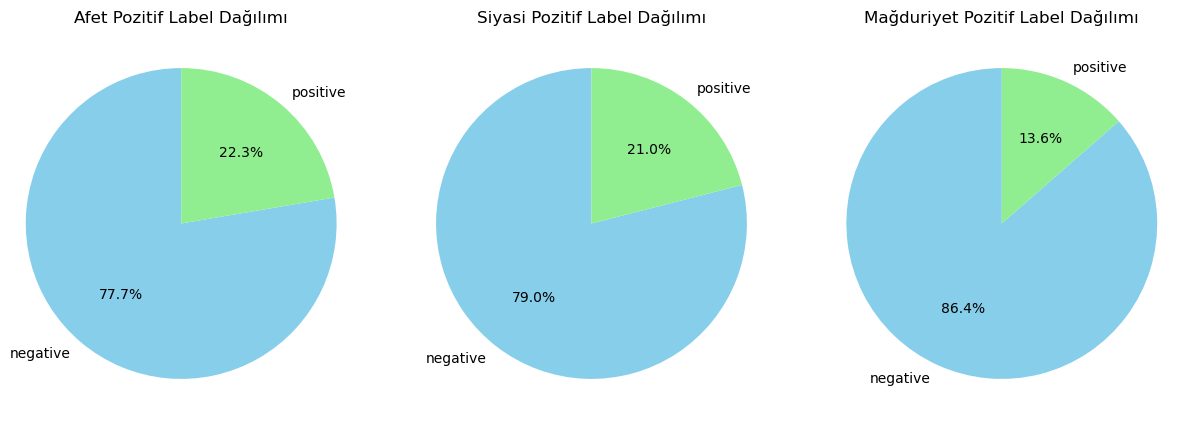

In [44]:
afet_positive = deprem[deprem['Afet'] == 1]['label']
siyasi_positive = deprem[deprem['Siyasi'] == 1]['label']
magduriyet_positive = deprem[deprem['Mağduriyet'] == 1]['label']

# Pozitif label içeren verilerin sayısını hesaplayın
afet_counts = afet_positive.value_counts()
siyasi_counts = siyasi_positive.value_counts()
magduriyet_counts = magduriyet_positive.value_counts()

# Pasta grafiğini çizmek için
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Afet
axes[0].pie(afet_counts, labels=afet_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[0].axis('equal')
axes[0].set_title('Afet Pozitif Label Dağılımı')

# Dini
axes[1].pie(siyasi_counts, labels=siyasi_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].axis('equal')
axes[1].set_title('Siyasi Pozitif Label Dağılımı')

# Siyasi
axes[2].pie(magduriyet_counts, labels=magduriyet_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[2].axis('equal')
axes[2].set_title('Mağduriyet Pozitif Label Dağılımı')

plt.show()

In [39]:
deprem.tail(25)

,content,temizlenmis,duygu_analizi,Afet,Siyasi,Mağduriyet,label,score
29975,Müdürlüğümüz personelleri tarafından 2022 Afet...,müdürlüğümüz personelleri afet tatbikat yılı k...,müdürlüğümüz personelleri tarafından afet tat...,1,0,1,negative,0.755800
29976,@smafatmabetul Dayanışma yaşatır #ŞartlıEYTyeH...,dayanışma yaşatır,dayanışma yaşatır,0,0,0,positive,0.970512
29977,Çanakkale’nin #biga ilçesi yakınlarında meydan...,çanakkalenin ilçesi yakınlarında meydana gelen...,çanakkalenin ilçesi yakınlarında meydana gele...,0,0,0,negative,0.962593
29978,Şimdi hukuk mekanizmasını çalıştırıp taciz vs....,hukuk mekanizmasını çalıştırıp taciz vs konula...,şimdi hukuk mekanizmasını çalıştırıp taciz vs ...,0,0,0,negative,0.960544
29979,#OEzdağaDokunma\nAMERİKANIN O ÇOCUKLARI \nHali...,amerikanin çocuklari halil falyalı,amerikanin o çocuklari halil falyalı,0,0,0,negative,0.993826
29980,"Erdoğan: 13 yaşında nişan, 14 yaşında evlilik ...",erdoğan yaşında nişan yaşında evlilik durumu k...,erdoğan yaşında nişan yaşında evlilik gibi b...,0,1,0,negative,0.638463
29981,@smafatmabetul Eller birleşince gūçlenir #Şart...,eller birleşince gūçlenir,eller birleşince gūçlenir,0,0,0,positive,0.992262
29982,Hatırlayalım; Şahan Gökbakar nam-diğer Recep İ...,hatırlayalım şahan gökbakar namdiğer recep ive...,hatırlayalım şahan gökbakar namdiğer recep ive...,0,0,0,negative,0.997546
29983,#eytistemiyoruz\n#deprem\nAMERİKANIN O ÇOCUKLA...,amerikanin çocuklari halil falyalı,amerikanin o çocuklari halil falyalı,0,0,0,negative,0.993826
29984,Amerikan Adalet Bakanlığı en büyük kripto bors...,amerikan adalet bakanlığı büyük kripto borsası...,amerikan adalet bakanlığı en büyük kripto bors...,1,0,0,negative,0.847020


In [40]:
#deprem=deprem.drop(["content","duygu_analizi"],axis=1)

In [41]:
deprem.head(25)

,content,temizlenmis,duygu_analizi,Afet,Siyasi,Mağduriyet,label,score
0,@odatv Bi sormak gerek; hristiyan avrupada ned...,bi sormak gerek hristiyan avrupada şiddetli de...,bi sormak gerek hristiyan avrupada neden şidd...,1,0,0,negative,0.668000
1,Az önce sanki bir deprem oldu,deprem,az önce sanki bir deprem oldu,1,0,0,negative,0.878860
2,"bi devir bitti kabul edelim, hadi söyle biz de...",bi devir bitti kabul edelim söyle bilelim beni...,bi devir bitti kabul edelim hadi söyle biz de ...,1,0,0,positive,0.879018
3,#osenebusene eytli olmadık busene eytli olalım...,eytli olmadık busene eytli olalım magdurları u...,eytli olmadık busene eytli olalım magdurlar...,0,0,0,negative,0.955436
4,"#Eyt99SonuHakkımız\nHaziranda mezun olduk ,anc...",haziranda mezun olduk ancak daki deprem atamal...,haziranda mezun olduk ancak daki deprem ile a...,1,0,0,negative,0.975898
5,@RTErdogan Sayın cumhurbaşkanım eyt yasasında ...,sayın cumhurbaşkanım eyt yasasında tarihin ol...,sayın cumhurbaşkanım eyt yasasında tarihin o...,0,0,1,negative,0.998124
6,Yürüyün çocuklar\nSiz bizi göremezsiniz\nBüyük...,yürüyün çocuklarsiz bizi göremezsinizbüyük yum...,yürüyün çocuklarsiz bizi göremezsinizbüyük yum...,1,0,0,positive,0.993956
7,Üst üste birkaç yüz beyazıt meydanı'ndan\nYine...,üst üste beyazıt meydanı silah sesleri duyar g...,üst üste birkaç yüz beyazıt meydanı silah sesl...,1,0,0,positive,0.508453
8,@Nyssaeta @Turkaai @Mimarietkiler @ononreklaml...,deprem olduktan gelcem deprem olmasını bekliyo...,deprem olduktan sonra gelcem oraya sadece ...,1,0,0,negative,0.995845
9,BİZİ DESTEKLEYİN DİYEN\n\nTEDBİR ÖNLEM\n\nİVME...,bizi destekleyin diyentedbir önlemivme hibe kr...,bizi destekleyin diyentedbir önlemivme hibe kr...,0,0,0,negative,0.999151


In [54]:
deprem.to_excel('final.xlsx',index=None)